In [497]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load the .fits file
file_path = "sat_interest_25/ETH_20250107_172151_01_satellite.fit"  # Replace with your actual file path
hdul = fits.open(file_path)

# Display the header information (optional)
#print("Header information:")
#print(hdul[0].header)

# Access the data (assuming it's a 2D array with shape [frequency, time])
data = hdul[0].data
print(data.shape)

# Extract frequency and time from header (if provided)
# You may need to adjust these keys based on your file
freq_axis = np.arange(data.shape[0])  # Dummy frequency axis if not provided
freq_axis = hdul[1].data[0][1] * 1000000
time_axis = np.arange(data.shape[1])  # Dummy time axis if not provided
time_axis = hdul[1].data[0][0] / 4

# Close the file
hdul.close()

# Choose a specific frequency index (modify as needed)
frequency_index = 80  # Example: choose the 50th frequency; adjust as per your data
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined

print(time_axis.size)



(200, 3600)
3600


In [498]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

c = 299792458 # speed of light in m/s
B = 5.49 # length of Baseline in meters
lam = c/chosen_frequency

def moving_average_smooth(data, window_size=3):
    """
    Smooths a 2D array along the first axis using a moving average.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_size (int): Size of the moving average window.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'),
        axis=0,
        arr=data
    )
    return smoothed_data


def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, omega, phi):
    return S*(1+np.cos(B *omega*x/lam + phi))

print(freq_axis[182])
print(lam)

2224187988.28125
0.12028684174484161


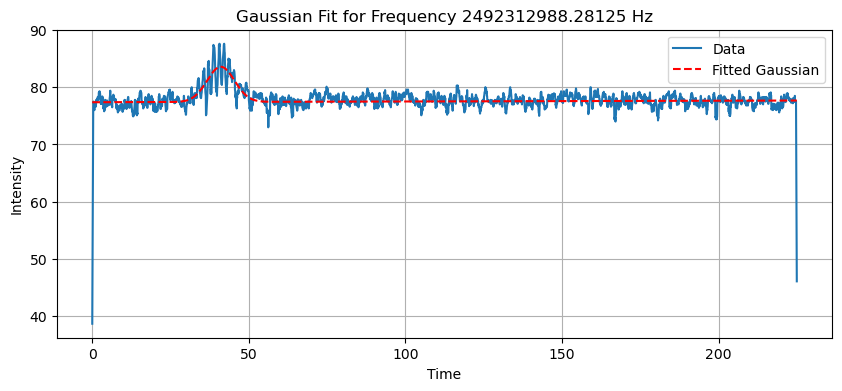

In [499]:
intensity = moving_average_smooth(data[frequency_index, :], window_size=10)

# Fit the Gaussian function (using example Gaussian-like data)
#gaussian_params, _ = curve_fit(gaussian, time_axis, intensity, p0=[17.5, 5720, 4640, 0, 1])
# Fit the Gaussian function with increased maxfev
gaussian_params, _ = curve_fit(
    gaussian,
    time_axis,
    intensity,
    p0=[17.5, 50, 50, 0, 11],
    #p0=[17.5, 5720, 4640, 0, 11],
    maxfev=50000  # Increase maxfev to 5000
)

I, mu, sigma, A, B = gaussian_params

# Generate fitted values for plotting
fitted_gaussian_linear = gaussian(time_axis, I, mu, sigma, A, B)
fitted_gaussian = gaussian(time_axis, I, mu, sigma, 0, 0)



# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, fitted_gaussian_linear, label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/tc/mprgbpgd4q91wy89m869r5c80000gn/T/ipykernel_20101/2013045098.py:2: RuntimeWarning: divide by zero encountered in divide
  intensity_no_gauss = intensity_no_linear/fitted_gaussian
/var/folders/tc/mprgbpgd4q91wy89m869r5c80000gn/T/ipykernel_20101/2013045098.py:2: RuntimeWarning: overflow encountered in divide
  intensity_no_gauss = intensity_no_linear/fitted_gaussian


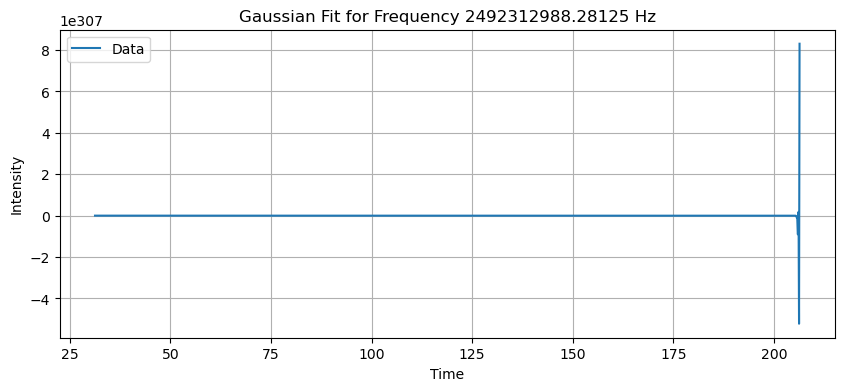

In [500]:
intensity_no_linear = intensity - A*time_axis - B
intensity_no_gauss = intensity_no_linear/fitted_gaussian
# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis[500:], intensity_no_gauss[500:], label='Data')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()


[ 0.82139033  1.03861871 -3.14159265]


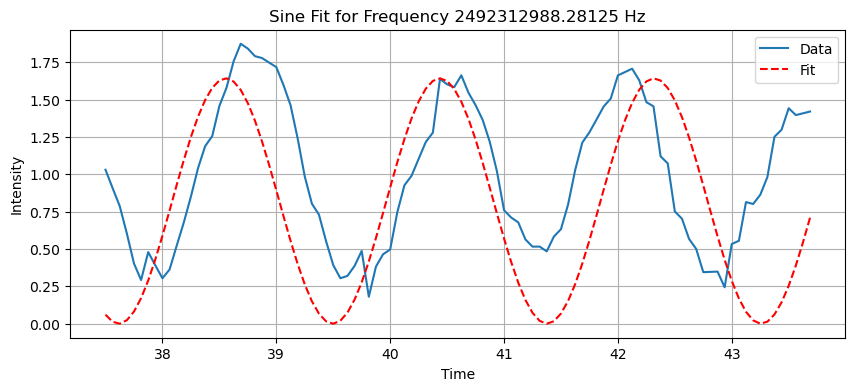

In [ ]:
#only relevant time sequence 
rel_time_start = 600
rel_time_stop = 700
intensity_no_gauss_rel = intensity_no_gauss[rel_time_start:rel_time_stop]
time_axis_rel = time_axis[rel_time_start:rel_time_stop]

def theoretical_fit_norm(x, S, omega, phi):
    return S*(1+np.cos(B *omega*0.005*x/lam + phi))

theo_params, _ = curve_fit(theoretical_fit_norm, time_axis_rel, intensity_no_gauss_rel, p0 = [0.6, 1, 0],bounds=([0, 0, -np.pi], [np.inf, np.inf, np.pi]),  maxfev=2000)
print(theo_params)
S, omega, phi = theo_params

fitted_sin_rel = theoretical_fit_norm(time_axis_rel, S, omega, phi)

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis_rel, intensity_no_gauss_rel, label='Data')
plt.plot(time_axis_rel, fitted_sin_rel, label='Fit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Sine Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.show()


Fitted Gaussian Parameters:
Amplitude: 6.036982420263138
Center (x0): 41.01245712789287
Width (sigma): 4.201277185843717
Baseline (y0): 77.59994131211074


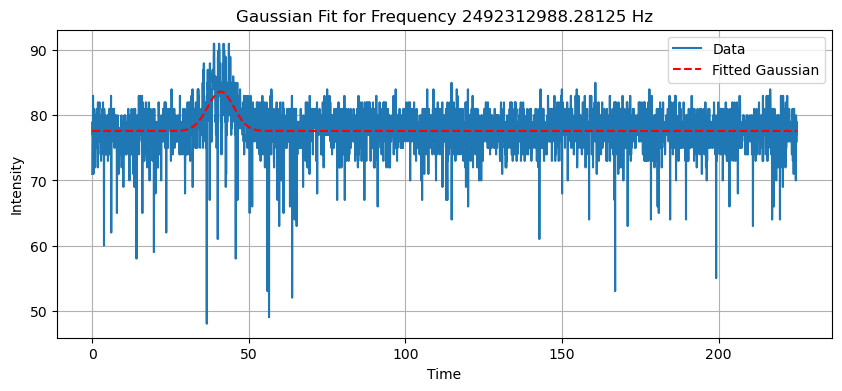

Peak Time Period: 32.61 to 49.42


In [502]:
from scipy.optimize import curve_fit

intensity = data[frequency_index, :]

# Define a Gaussian function
def gaussian(x, a, x0, sigma, y0):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0

# Estimate initial parameters for the Gaussian
a_initial = np.max(intensity) - np.min(intensity)  # Amplitude guess
x0_initial = time_axis[np.argmax(intensity)]  # Peak position guess
sigma_initial = np.std(time_axis) / 10  # Width guess
y0_initial = np.min(intensity)  # Baseline guess
initial_guess = [a_initial, x0_initial, sigma_initial, y0_initial]

# Fit the Gaussian
params, covariance = curve_fit(gaussian, time_axis, intensity, p0=initial_guess)

# Extract fitted parameters
a_fit, x0_fit, sigma_fit, y0_fit = params
print(f"Fitted Gaussian Parameters:\n"
      f"Amplitude: {a_fit}\n"
      f"Center (x0): {x0_fit}\n"
      f"Width (sigma): {sigma_fit}\n"
      f"Baseline (y0): {y0_fit}")

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, gaussian(time_axis, *params), label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()

# Return the starting values of the Gaussian
start_time = x0_fit - 2 * sigma_fit
end_time = x0_fit + 2 * sigma_fit
print(f"Peak Time Period: {start_time:.2f} to {end_time:.2f}")
dT = 2*np.sqrt(2*np.log(2))*sigma_fit
dTT = end_time - start_time

In [503]:
import sympy as sp

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians
t = dTT
omega = 0.005

# Define the equation
equation = r**3 + R*r**2 - (G * M ) / omega**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")


Solution 1: -5915358.37497202 + 0.e-14*I
Solution 2: -1885284.48487899 + 0.e-14*I
Solution 3: 1429642.85985101 + 0.e-14*I


List of Satellite with respective height and time of culmination pass

In [504]:
from skyfield.api import Topos, load, EarthSatellite
from datetime import datetime
import requests

# Function to download TLE data from CelesTrak
def download_tle():
    url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    tle_lines = response.text.strip().splitlines()
    return tle_lines

# Load satellites using EarthSatellite class
def load_satellites(tle_lines):
    satellites = []
    for i in range(0, len(tle_lines), 3):
        name = tle_lines[i].strip()
        if "STARLINK" not in name.upper():  # Exclude Starlink satellites
            line1 = tle_lines[i + 1].strip()
            line2 = tle_lines[i + 2].strip()
            satellite = EarthSatellite(line1, line2, name, load.timescale())
            satellites.append(satellite)
    return satellites

# Function to predict satellite culmination passes for a given location and time range
def predict_passes(satellites, location, start_time, end_time):
    ts = load.timescale()
    observer = Topos(latitude_degrees=location[0], longitude_degrees=location[1])

    print(f"Predicting satellite culminations for location: {location}")
    for satellite in satellites:
        t, events = satellite.find_events(observer, start_time, end_time, altitude_degrees=30.0)
        for ti, event in zip(t, events):
            if event == 1:  # 1 corresponds to 'culminate'
                # Calculate satellite altitude during culmination
                difference = satellite - observer
                topocentric = difference.at(ti)
                altitude = topocentric.distance().km  # Altitude in kilometers
                print(f"{satellite.name} culminate at {ti.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC, altitude: {altitude:.2f} km")

# Main function
if __name__ == "__main__":
    # Download and load TLE data
    tle_lines = download_tle()
    satellites = load_satellites(tle_lines)

    # Set location for Zurich, Switzerland (latitude, longitude)
    location = (47.3769, 8.5417)

    # Set prediction time range (8 Jan 2025, 01:00 UTC to 8 Jan 2025, 02:00 UTC)
    ts = load.timescale()
    start_time = ts.utc(2025, 1, 7, 17, 0, 0)  # 8 Jan 2025, 01:00 UTC
    end_time = ts.utc(2025, 1, 7, 17, 40, 0)    # 8 Jan 2025, 02:00 UTC

    # Predict satellite culmination passes
    predict_passes(satellites, location, start_time, end_time)


Predicting satellite culminations for location: (47.3769, 8.5417)
LAGEOS 1 culminate at 2025-01-07 17:30:05 UTC, altitude: 7197.81 km
LAGEOS 2 culminate at 2025-01-07 17:25:29 UTC, altitude: 6001.22 km
ODIN culminate at 2025-01-07 17:02:10 UTC, altitude: 862.47 km
MAROC-TUBSAT culminate at 2025-01-07 17:28:36 UTC, altitude: 1616.67 km
COSMOS 2385 culminate at 2025-01-07 17:23:23 UTC, altitude: 1620.48 km
COSMOS 2386 culminate at 2025-01-07 17:38:35 UTC, altitude: 2082.18 km
CUTE-1 (CO-55) culminate at 2025-01-07 17:04:20 UTC, altitude: 873.43 km
CUBESAT XI-IV (CO-57) culminate at 2025-01-07 17:31:51 UTC, altitude: 1167.52 km
SHIJIAN-6 01A (SJ-6 01A) culminate at 2025-01-07 17:19:55 UTC, altitude: 734.43 km
HELIOS 2A culminate at 2025-01-07 17:26:52 UTC, altitude: 741.86 km
SJ-7 culminate at 2025-01-07 17:02:08 UTC, altitude: 534.05 km
HINODE (SOLAR-B) culminate at 2025-01-07 17:07:37 UTC, altitude: 761.21 km
GLOBALSTAR M071 culminate at 2025-01-07 17:29:16 UTC, altitude: 1604.82 km
COS